## Imports para análise e limpeza dos dados

In [30]:
import pandas_gbq as pg
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import plotly.express as px

from google.oauth2 import service_account
import pickle
import pathlib
import json
import os
import base64
import logging
import traceback

from dotenv import load_dotenv


## Imports para Machine Learning

In [31]:
# Pré-processamento e divisão para treino e testes
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Algoritmos para seleção do melhor modelo de ML
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Métricas para validação de cada modelo
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

In [32]:
# environment variables loading
load_dotenv()

logger = logging.getLogger()
handler = logging.StreamHandler()
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)

# Query do dataset que será base para o modelo
sql_no_com = """
select * 
from `civic-athlete-325820.pji4.dataset_analysis`

limit 100000
"""


## Leitura do Dataset

In [33]:
# Leitura dos dados no banco GCP. Para caso encontre algum erro, o script irá fazer o log deste erro
try:
    print('Running')

    credentials = service_account.Credentials.from_service_account_info(json.loads(base64.b64decode(os.environ.get('CRED'))))
    df = pg.read_gbq(sql_no_com, project_id="civic-athlete-325820", credentials=credentials)

    print('Query done')

except Exception as e:
    print(e)
    print(traceback.format_exc())

Requesting query... 
Requesting query... 
Converted retries value: 3 -> Retry(total=3, connect=None, read=None, redirect=None, status=None)
Converted retries value: 3 -> Retry(total=3, connect=None, read=None, redirect=None, status=None)
Making request: POST https://oauth2.googleapis.com/token
Making request: POST https://oauth2.googleapis.com/token
Starting new HTTPS connection (1): oauth2.googleapis.com:443
Starting new HTTPS connection (1): oauth2.googleapis.com:443


Running


https://oauth2.googleapis.com:443 "POST /token HTTP/1.1" 200 None
https://oauth2.googleapis.com:443 "POST /token HTTP/1.1" 200 None
Starting new HTTPS connection (1): bigquery.googleapis.com:443
Starting new HTTPS connection (1): bigquery.googleapis.com:443
https://bigquery.googleapis.com:443 "POST /bigquery/v2/projects/civic-athlete-325820/jobs?prettyPrint=false HTTP/1.1" 200 None
https://bigquery.googleapis.com:443 "POST /bigquery/v2/projects/civic-athlete-325820/jobs?prettyPrint=false HTTP/1.1" 200 None
Query running...
Query running...
Job ID: 2f558336-2774-4e23-a15c-e336a7acfbf2
Job ID: 2f558336-2774-4e23-a15c-e336a7acfbf2
Query done.
Cache hit.

Query done.
Cache hit.

https://bigquery.googleapis.com:443 "GET /bigquery/v2/projects/civic-athlete-325820/queries/2f558336-2774-4e23-a15c-e336a7acfbf2?maxResults=0&location=US&prettyPrint=false HTTP/1.1" 200 None
https://bigquery.googleapis.com:443 "GET /bigquery/v2/projects/civic-athlete-325820/queries/2f558336-2774-4e23-a15c-e336a7acf

Query done


In [34]:
# Amostra dos dados resultantes da query
df.head(5)

,cnpj_basico,NOME_FANTASIA,CNAE_FISCAL_PRINCIPAL,cnae_descricao,cep,UF,municipio,ident_matriz_filial,dt_sit_cadastral,sit_cadastral,dt_inicio_ativ,razao_social,capital_social,porte,natureza_juridica,month,year
0,42720799,None,4712100,"Comércio varejista de mercadorias em geral, co...",58978000,PB,SANTA INES,Matriz,2021-07-14,ATIVA,2021-07-14,VALQUIRIA LIERGE DE MELO RAMALHO 07238540410,500000,MICRO EMPRESA,Empresário (Individual),7,2021
1,44376719,JK MAGAZINE VAZ,4781400,Comércio varejista de artigos do vestuário e a...,68830000,PA,PONTA DE PEDRAS,Matriz,2021-11-24,ATIVA,2021-11-24,KEIZY RODRIGUES VIEIRA,10000000,MICRO EMPRESA,Empresário (Individual),11,2021
2,46345675,NOVINHO MOTO PECAS,4541207,Comércio a varejo de peças e acessórios usados...,65415000,MA,COROATA,Matriz,2022-05-11,ATIVA,2022-05-11,CARLOS ANDRE DE OLIVEIRA BRITO 62292509342,500000,MICRO EMPRESA,Empresário (Individual),5,2022
3,45073435,QUALITY INCELL,9512600,Reparação e manutenção de equipamentos de comu...,62900000,CE,RUSSAS,Matriz,2022-01-30,ATIVA,2022-01-30,JOAO ADAIRLON DE BRITO 07221204357,100000,MICRO EMPRESA,Empresário (Individual),1,2022
4,41388506,SEGURAR EVENTOS,8230001,"Serviços de organização de feiras, congressos,...",39404522,MG,MONTES CLAROS,Matriz,2021-03-29,ATIVA,2021-03-29,HERMANO CESAR FONSECA FREITAS 04016182697,100000,MICRO EMPRESA,Empresário (Individual),3,2021


In [35]:
# Renomeando as colunas para melhorar a leitura dos dados
df.rename(columns={
        'cnpj_basico': 'CNPJ', 
        'NOME_FANTASIA': 'Nome Fantasia', 
        'CNAE_FISCAL_PRINCIPAL': 'CNAE',
        'cnae_descricao': 'Descricao', 
        'cep': 'CEP', 
        'UF': 'UF', 
        'municipio': 'Municipio', 
        'ident_matriz_filial': 'Matriz/Filial',
        'dt_sit_cadastral': 'Data da Situação Cadastral', 
        'sit_cadastral': 'Situação Cadastral', 
        'dt_inicio_ativ': 'Data de Inicio de Atividades', 
        'razao_social': 'Razao Social',
        'capital_social': 'Capital', 
        'porte': 'Porte', 
        'natureza_juridica': 'Natureza Juridica', 
        'month': 'Mes', 
        'year': 'Ano'
}, inplace=True)

In [36]:
# Descrevendo os dados
df.describe()

,CNPJ,CNAE,Capital,Mes,Ano
count,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000,100000.000000
mean,4.605545e+07,5.875147e+06,9.630045e+09,6.331230,2020.428810
std,6.308147e+06,2.213274e+06,4.984922e+11,3.319938,6.127964
min,4.127377e+07,1.113020e+05,0.000000e+00,1.000000,1955.000000
25%,4.336912e+07,4.722901e+06,1.000000e+05,4.000000,2021.000000
50%,4.504558e+07,5.235850e+06,3.000000e+05,6.000000,2022.000000
75%,4.673353e+07,8.020001e+06,1.000000e+06,9.000000,2022.000000
max,9.755427e+07,9.700500e+06,1.000000e+14,12.000000,2023.000000


In [37]:
# Verificando dados nulos

# Pelo fato de termos feito a modelagem dos dados previamente para análises em dashboard, os dados deste df estão em boa condição.
# Os dados que estão nulos não serão considerados pelo modelo, então não serão feitos os tratamentos nessas colunas.
df.isnull().sum()

CNPJ                                0
Nome Fantasia                   22935
CNAE                                0
Descricao                           0
CEP                                97
UF                                  0
Municipio                           0
Matriz/Filial                       0
Data da Situação Cadastral          0
Situação Cadastral                  0
Data de Inicio de Atividades        0
Razao Social                        0
Capital                             0
Porte                               0
Natureza Juridica                   0
Mes                                 0
Ano                                 0
dtype: int64

In [38]:
# Selecionando as colunas que serão trabalhadas na análise e na construção do modelo

# df.columns
df = df[['CNAE', 'UF', 'Matriz/Filial', 'Razao Social', 'Capital', 'Porte', 'Natureza Juridica', 'Situação Cadastral']]
df

,CNAE,UF,Matriz/Filial,Razao Social,Capital,Porte,Natureza Juridica,Situação Cadastral
0,4712100,PB,Matriz,VALQUIRIA LIERGE DE MELO RAMALHO 07238540410,500000,MICRO EMPRESA,Empresário (Individual),ATIVA
1,4781400,PA,Matriz,KEIZY RODRIGUES VIEIRA,10000000,MICRO EMPRESA,Empresário (Individual),ATIVA
2,4541207,MA,Matriz,CARLOS ANDRE DE OLIVEIRA BRITO 62292509342,500000,MICRO EMPRESA,Empresário (Individual),ATIVA
3,9512600,CE,Matriz,JOAO ADAIRLON DE BRITO 07221204357,100000,MICRO EMPRESA,Empresário (Individual),ATIVA
4,8230001,MG,Matriz,HERMANO CESAR FONSECA FREITAS 04016182697,100000,MICRO EMPRESA,Empresário (Individual),ATIVA
...,...,...,...,...,...,...,...,...
99995,4772500,SP,Matriz,BUCKINGHAM COSMETICOS LTDA,10000000,DEMAIS,Sociedade Empresária Limitada,ATIVA
99996,5320202,SP,Matriz,FILIPE MATTES 45311038829,10000,MICRO EMPRESA,Empresário (Individual),ATIVA
99997,8219999,SP,Matriz,DEISE SILVA 07281857764,50000,MICRO EMPRESA,Empresário (Individual),ATIVA
99998,4923001,RS,Matriz,PAULO CESAR SILVA DOS SANTOS 53777018015,500000,MICRO EMPRESA,Empresário (Individual),ATIVA


## Análise de boxplot

A análise da divisão dos dados por quartis, neste caso da coluna de capital financeiro, mostrará onde os dados estão distrituídos e, conforme feita a análise, pudemos perceber como os outliers fizeram uma grande diferença neste gráfico.

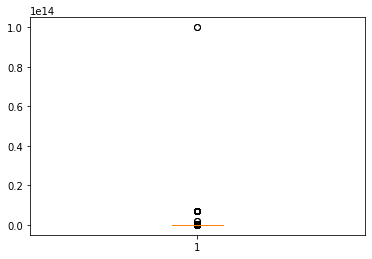

In [39]:
# Verificando a divisão dos dados por meio do boxplot

plt.boxplot(df["Capital"])
plt.show()

In [40]:
# Verificação dos dados máximo e mínimo, além da média

mx = df['Capital'].max()
mn = df['Capital'].min()
mean = df.Capital.mean()

f'Os valores são: máx = {mx}, min = {mn}, média = {round(mean, 2)}'

'Os valores são: máx = 99999999999900, min = 0, média = 9630044874.39'

In [41]:
# Verificando e Removendo outliers

df_filtered = df.copy() 

print(df_filtered['Capital'].mean())

df_filtered_mean, df_filtered_std = np.mean(df_filtered['Capital']), np.std(df_filtered['Capital'])
cut_off = df_filtered_std * 3

lower, upper = df_filtered_mean - cut_off, df_filtered_mean + cut_off
df_filtered = df_filtered.loc[~((df_filtered['Capital'] < lower) | (df_filtered['Capital'] > upper))]

# type(idx[0])
df_filtered['Capital'].mean(), df_filtered.count()


9630044874.39258


(686138430.6739842,
 CNAE                  99897
 UF                    99897
 Matriz/Filial         99897
 Razao Social          99897
 Capital               99897
 Porte                 99897
 Natureza Juridica     99897
 Situação Cadastral    99897
 dtype: int64)

# Análisando os dados

Inicialmente, faremos uma verificação de capital por empresas, filtrando por estado e situação cadastral

A ideia é entender: quais são os estados com maior capital aplicado em empresas, e se isso se correlaciona com o número de empresas por UF

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
findfont: score(FontEntry(fname='c:\\Users\\sergi\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='c:\\Users\\sergi\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='c:\\Users\\sergi\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', variant='normal', w

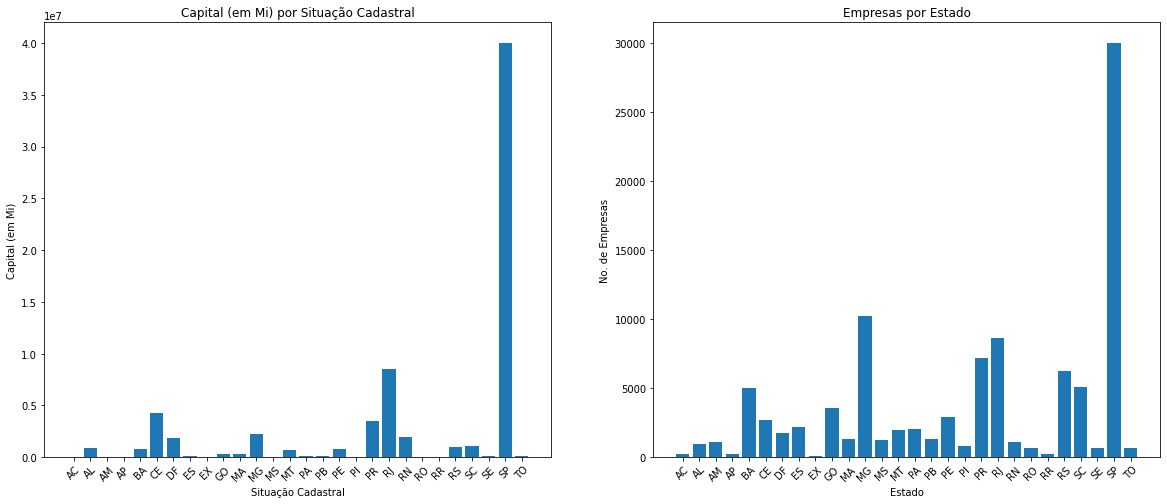

In [42]:
df_filtered['Capital em Milhões'] = df_filtered['Capital'] / 1000000

v1 = df_filtered[['UF', 'Capital em Milhões']].groupby(['UF']).sum('Capital em Milhões')
v2 = df_filtered[['UF', 'Capital']].groupby(['UF']).count()

plt.subplots(figsize=(20,8))

plt.subplot(1,2,1)
plt.bar(v1['Capital em Milhões'].index, v1['Capital em Milhões'])
plt.title("Capital (em Mi) por Situação Cadastral")
plt.xticks(rotation=45)
plt.xlabel("Situação Cadastral")
plt.ylabel("Capital (em Mi)")

plt.subplot(1,2,2)
plt.bar(v2['Capital'].index, v2['Capital'])
plt.title("Empresas por Estado")
plt.xticks(rotation=45)
plt.xlabel("Estado")
plt.ylabel("No. de Empresas")

plt.show()
# v1['Capital'].index

## Respostas

Embora, nesta amostra, tenhamos uma disparidade muito grande para as empresas e capital investido em São Paulo, outros estados com um bom número de empresas não apresentam, em contrapartida, um alto capital na soma por UF

### Agora, veremos quais são as principais naturezas jurídicas cadastras pelo governo

Text(0, 0.5, 'Contagem')

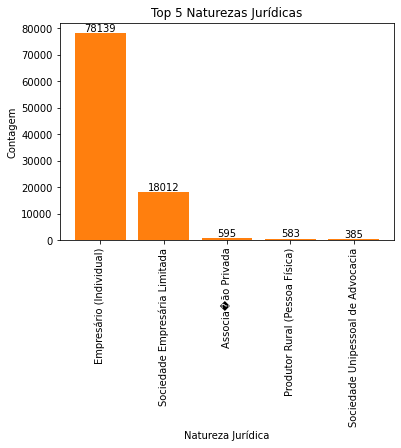

In [43]:
v1 = df_filtered['Natureza Juridica'].value_counts().sort_values(ascending=False).head(5)

fig, ax = plt.subplots()

bars =  ax.bar(v1.index, v1.values)
ax.bar_label(bars)

plt.bar(v1.index, v1.values)
plt.title("Top 5 Naturezas Jurídicas")
plt.xticks(rotation=90)
plt.xlabel("Natureza Jurídica")
plt.ylabel("Contagem")

Podemos ver que, com os dados estando circundados ao perído pré (2018-29), pandemia e pós-pandemia, o número de empresários individuais tem um número 434% maior 

Os dados presentes no dataframe mostram empresas criadas de 2018 em diante, mas quantas se encontram ativas atualmente?

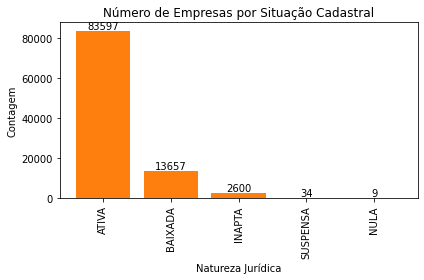

In [44]:
v1 = df_filtered['Situação Cadastral'].value_counts().sort_values(ascending=False)

fig, ax = plt.subplots()

bars =  ax.bar(v1.index, v1.values)
ax.bar_label(bars)

plt.bar(v1.index, v1.values)
plt.title("Número de Empresas por Situação Cadastral")
plt.xticks(rotation=90)
plt.xlabel("Natureza Jurídica")
plt.ylabel("Contagem")

plt.tight_layout()

In [45]:
pct = df_filtered[df_filtered['Situação Cadastral'] == 'ATIVA'].count() / df_filtered.count()
ativo = df_filtered[df_filtered['Situação Cadastral'] == 'ATIVA'].count()

f'Atualmente, das empresas criadas a partir de 2018, {pct[0]}% das empresa estão ativas, num total de {ativo[0]}'

'Atualmente, das empresas criadas a partir de 2018, 0.8368319368950019% das empresa estão ativas, num total de 83597'

In [46]:
# Pré-processamento
# De forma a ajudar o modelo de machine learning a tomar a melhor decisão, iremos transformar os dados quantitativos de capital em intervalos

# df_test = df_filtered.copy()

for n in df_filtered['Capital']:
    if n < 100000:
        df_filtered['Interval'] = 'Menor que 100k'
    elif (n >= 100000) and (n < 500000):
        df_filtered['Interval'] = 'Entre 100k e 500k' 
    elif (n >= 500000) and (n < 1000000):
        df_filtered['Interval'] = 'Entre 500k e 1M' 
    else:
        df_filtered['Interval'] = 'Maior que 1M'


## Conversão de dados categóricos para numéricos

In [47]:
# Aqui estamos convertendo textos para registros numéricos, permitindo que o algoritmo de machine learning leia as colunas

label_encoder = preprocessing.LabelEncoder()

df_ml = df_filtered.copy()
df_ml = df_ml.drop(columns=['CNAE', 'Razao Social', 'Capital', 'Capital em Milhões']) #, inplace=True
df_ml['Situação Cadastral'] = label_encoder.fit_transform(df_ml['Situação Cadastral'])
df_ml['UF'] = label_encoder.fit_transform(df_ml['UF'])
df_ml['Matriz/Filial'] = label_encoder.fit_transform(df_ml['Matriz/Filial'])
df_ml['Interval'] = label_encoder.fit_transform(df_ml['Interval'])
df_ml['Porte'] = label_encoder.fit_transform(df_ml['Porte'])
df_ml['Natureza Juridica'] = label_encoder.fit_transform(df_ml['Natureza Juridica'])
df_ml['Situação Cadastral'] = label_encoder.fit_transform(df_ml['Situação Cadastral'])

df_ml

,UF,Matriz/Filial,Porte,Natureza Juridica,Situação Cadastral,Interval
0,15,1,2,13,0,0
1,14,1,2,13,0,0
2,10,1,2,13,0,0
3,5,1,2,13,0,0
4,11,1,2,13,0,0
...,...,...,...,...,...,...
99995,26,1,0,29,0,0
99996,26,1,2,13,0,0
99997,26,1,2,13,0,0
99998,23,1,2,13,0,0


# Criação do algoritmo de machine learning

Agora iremos tentar prever a situação cadastral que terá uma empresa de acordo com os atributos colocados acima

In [48]:
#Criando uma lista de algoritmos para comparação e fazendo um split de dados de teste e treino

x = df_ml.drop(columns=['Situação Cadastral'])
y = df_ml['Situação Cadastral']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.25, random_state = 0)

In [49]:
# Criação dos modelos convencionais:
lista_modelos = [GaussianNB(),
                 DecisionTreeClassifier(),
                 SVC(),
                 RandomForestClassifier(n_estimators = 500),
                 KNeighborsClassifier(n_neighbors=3),
                 XGBClassifier()
                ]
for modelo in lista_modelos:
    modelo.fit(x_train, y_train)

In [50]:
# Com a validação cruzada podemos fazer um double check e verificar se os registros de acurácia se aplicam ao dataset todo

lista_modelos = [GaussianNB(),
                 DecisionTreeClassifier(),
                 SVC(),
                 RandomForestClassifier(n_estimators = 500),
                 KNeighborsClassifier(n_neighbors=3),
                 XGBClassifier()
                ]

for modelo in lista_modelos:
    modelo.fit(x_train, y_train)
    val_res_clf = cross_val_score(modelo, x_test, y_test, cv=10)
    print(modelo, val_res_clf.mean())

c:\Users\sergi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=10.



GaussianNB() 0.11390950165017877


c:\Users\sergi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=10.



DecisionTreeClassifier() 0.8404803939266753


c:\Users\sergi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=10.



SVC() 0.8380781036523253


c:\Users\sergi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=10.



RandomForestClassifier(n_estimators=500) 0.8400800897025189


c:\Users\sergi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=10.



KNeighborsClassifier(n_neighbors=3) 0.7701773433163832


c:\Users\sergi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=10.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...) 0.8406405540932547


In [51]:
# Previsões
previsoes = []
taxa_acerto = []
for modelo in lista_modelos:
    previsoes.append(modelo.predict(x_test))
    taxa_acerto.append(accuracy_score(y_test, previsoes[-1]))

## Métricas de desempenho para os modelos utilizados:

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

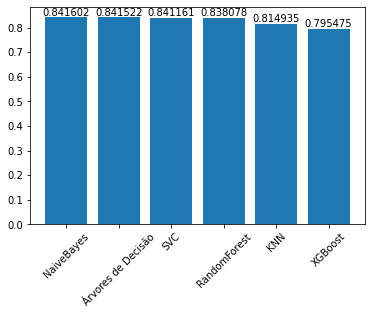

In [55]:
models = ["NaiveBayes", "Árvores de Decisão", "SVC", "RandomForest", "KNN","XGBoost"]
df_res = pd.DataFrame({"Modelos":models, "TxAcerto":taxa_acerto})
df_res = df_res.set_index("Modelos")
grafico = df_res.TxAcerto.sort_values(ascending=False)

fig, ax = plt.subplots()

bars = ax.bar(models, grafico)
ax.bar_label(bars)

plt.xticks(rotation=45)

## Definindo o algoritmo

Como o algoritmo de melhor acerto foi o de Arvore de Decisão (veja a Cross Vaidation junto ao score apresentado no gráfico acima), ele será transportado para ser feito o deploy

Faremos também um detalhamento sobre o modelo, trazendo a média de validação sobre cross validation


In [53]:
Dtree = DecisionTreeClassifier().fit(x_train, y_train)

In [54]:
# salvando o modelo para o deploy em produção

pickle.dump(Dtree, open(pathlib.Path.cwd() / 'clf_pji4.pkl', 'wb'))